## Create a notebook to perform Runge-Kutta integration for multiple coupled variables.

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Define our coupled derivatives to integrate

In [56]:
def dydx(x,y):
    
    #set the derivatives
    
    #our eqn is d^2y/dx^2 = -y
    
    #so we can write
    #dydx = z
    #dzdx = -y
    
    #we will set y = y[0]
    #we will set z = y[1]
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dzdx = z
    y_derivs[0] = y[1]
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #here we have to return an array
    return y_derivs

## Define the 4th order RK method

In [57]:
def rk4_mv_core(dy,xi,yi,nv,h):
    
    #declare k? arrays     ?= wildcard, any digit from 0 to 9
    k1 = np.zeros(nv)      #each k gives derivatives for each eqn solving simultaneously
    k2 = np.zeros(nv)      #k2 depends on k1's we were using
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    #define x at 1/2 step
    x_ipoh = xi + 0.5*h
    
    #define x at 1 step
    x_ipo = xi + h
    
    #declare a temp y aray
    y_temp = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]    #: - evolve so will compute new number (an update)
    
    #get k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + k3[:]     
    y_derivs = dydx(x_ipo,y_temp)
    k4[:] = h*y_derivs[:]
    
    #advance y by a step h
    yipo = yi + (k1 + 2*k2 + 2*k3 + k4)/6.
    
    return yipo

## Define an adaptive step size driver for RK4

In [58]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #define safety scale
    SAFETY    = 0.9
    H_NEW_FAC = 2.0  #max factor by which we'll take a bigger step
    
    #set a maximum number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv, 2*tol) 
    
    #remember the step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol > 1.0):
        
        #estimate our error by taking one step of size h
        #vs. two steps of size h/2
        y_2  = rk4_mv_core(dydx,x_i,y_i,nv,h_step)   #first half step
        y_1  = rk4_mv_core(dydx,x_i,y_i,nv,0.5*h_step)   #second half step WRT first half step
        y_11 = rk4_mv_core(dydx,x_i+0.5*h_step,y_1,nv,0.5*h_step)  #lead to full step
        
        #compute an error
        Delta = np.fabs(y_2 - y_11)
        
        #if the error is too large, take a smaller step
        if(Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check iteration
        if(i>=imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ",i)
            
        #iterate
        i+=1
        
    #next time, try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, a new step, and the step we actually took
    return y_2, h_new, h_step

## Define a wrapper for R4

In [59]:
def rk4_mv(dydx,a,b,y_a,tol):
    
    #dfdx is the derivative wrt x
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very small!
    h = 1.0e-4 * (b-a)
    
    #set a maximum number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #set the number of coupled odes to the
    #size of y_a
    nv = len(y_a)
    
    #set the initial conditions
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calc y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break
            flag = 0
        
        #update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        #prevent too many iterations
        if(i>=imax):
            
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ",i)
            
        #iterate
        i += 1
        
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb = %9.8f" % (i,xi, h_step, b)
        print(s)
        
        #break if new xi is == b
        if(xi==b):
            flag = 0
            
    #return the answer
    return x,y

## Perform the integration

In [60]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perform the integration
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b = 6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b = 6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b = 6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b = 6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b = 6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b = 6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b = 6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b = 6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b = 6.28318531
i =  10	x = 0.46816761	h = 0.14709684	b = 6.28318531
i =  11	x = 0.60535502	h = 0.13718741	b = 6.28318531
i =  12	x = 0.74522296	h = 0.13986794	b = 6.28318531
i =  13	x = 0.88873209	h = 0.14350913	b = 6.28318531
i =  14	x = 1.02700188	h = 0.13826979	b = 6.28318531
i =  15	x = 1.16350434	h = 0.13650247	b = 6.28318531
i =  16	x = 1.29828215	h = 0.13477781	b = 6.28318531
i =  17	x = 1.43207856	h = 0.13379641	b = 6.28318531
i =  18	x = 1.56536018	h = 0.13328163	b = 6.28318531
i =  19	x = 1.69861470	h = 0.13325451	b = 6.28

## Plot the result

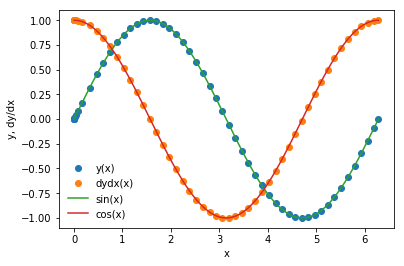

In [61]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx), label='sin(x)')
plt.plot(xx,np.cos(xx), label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)

## Plot the error

In [ ]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error, label="y(x) Error")
plt.plot(x, dydx_error, label="dydx(x) Error")
plt.legend(frameon = False)